# The following notebook merges PolyA and RiboD datasets
* Datasets are unbalanced in terms of disease
* PolyA datasets has many more samples compared to RiboD
* Balacing of diseases is done based on the disease prevalence of RiboD


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading PolyA and RiboD gene expression data

In [2]:
# the following files were prepared during setup.py
# both Poly.tsv and Ribo.tsv are described by the same genes
poly = pd.read_csv('../../data_test/Poly.tsv', sep='\t', index_col=0)
ribo = pd.read_csv('../../data_test/Ribo.tsv', sep='\t', index_col=0)

In [3]:
poly.shape

(12236, 5000)

In [4]:
ribo.shape

(296, 5000)

## Loading Clinical Metadata for both PolyA and RiboD data

In [5]:
poly_clinical = pd.read_csv('../../data_test/clinical_TumorCompendium_v10_PolyA_2019-07-25.tsv', sep='\t', index_col=0)
ribo_clinical = pd.read_csv('../../data_test/TreehousePEDv9_Ribodeplete_clinical_metadata.2019-03-25.tsv', sep='\t', index_col=0)

## Removing diseases that are represented by one sample

In [6]:
poly_single_disease = poly_clinical.disease.value_counts().index.values[(poly_clinical.disease.value_counts()==1)]
ribo_single_disease = ribo_clinical.disease.value_counts().index.values[(ribo_clinical.disease.value_counts()==1)]

## Filling any NA values in the clinical files
* one sample with NA values

In [7]:
poly_clinical_dropped = poly_clinical.loc[~poly_clinical.disease.str.contains('|'.join(poly_single_disease)).fillna(True)] #one na sample
ribo_clinical_dropped = ribo_clinical.loc[~ribo_clinical.disease.str.contains('|'.join(ribo_single_disease)).fillna(True)] #one na sample


## Collecting common diseases from PolyA and RiboD

In [8]:
common_diseases = set(ribo_clinical_dropped.disease.value_counts().index).intersection(poly_clinical_dropped.disease.value_counts().index)

In [9]:
# Displaying common diseases
(common_diseases)

{'Ewing sarcoma',
 'acute lymphoblastic leukemia',
 'acute myeloid leukemia',
 'atypical teratoid/rhabdoid tumor',
 'choroid plexus carcinoma',
 'dysembryoplastic neuroepithelial tumor',
 'ependymoma',
 'fibrolamellar hepatocellular carcinoma',
 'glioblastoma multiforme',
 'glioma',
 'lymphoma',
 'medulloblastoma',
 'neuroblastoma',
 'sarcoma',
 'wilms tumor'}

## Selecting samples from PolyA and RiboD that match common_diseases

In [10]:
poly_masked = np.arange(poly_clinical_dropped.shape[0])
ribo_masked = np.arange(ribo_clinical_dropped.shape[0])
poly_clinical_disease_common_idx = []
ribo_clinical_disease_common_idx = []

for disease in common_diseases:
    poly_disease_booleans = (poly_clinical_dropped.disease==disease).values
    ribo_disease_booleans = (ribo_clinical_dropped.disease==disease).values
    poly_disease_idx = poly_masked[poly_disease_booleans]
    ribo_disease_idx = ribo_masked[ribo_disease_booleans]

    poly_clinical_disease_common_idx += list(poly_disease_idx)
    ribo_clinical_disease_common_idx += list(ribo_disease_idx)
    
poly_clinical_disease_common = poly_clinical_dropped.iloc[poly_clinical_disease_common_idx]
ribo_clinical_disease_common = ribo_clinical_dropped.iloc[ribo_clinical_disease_common_idx]

In [11]:
ribo_clinical_dropped.shape

(264, 6)

# Checking prevalence of diseases in both datasets...

In [12]:
poly_clinical_disease_common.disease.value_counts()/poly_clinical_disease_common.disease.value_counts().sum()

glioma                                    0.276760
acute lymphoblastic leukemia              0.201246
acute myeloid leukemia                    0.169721
glioblastoma multiforme                   0.065982
neuroblastoma                             0.065982
wilms tumor                               0.048754
medulloblastoma                           0.046188
ependymoma                                0.036290
Ewing sarcoma                             0.030059
sarcoma                                   0.021994
lymphoma                                  0.018328
choroid plexus carcinoma                  0.009531
dysembryoplastic neuroepithelial tumor    0.005132
fibrolamellar hepatocellular carcinoma    0.002933
atypical teratoid/rhabdoid tumor          0.001100
Name: disease, dtype: float64

In [13]:
ribo_clinical_disease_common.disease.value_counts()/ribo_clinical_disease_common.disease.value_counts().sum()

glioma                                    0.314655
glioblastoma multiforme                   0.172414
ependymoma                                0.103448
fibrolamellar hepatocellular carcinoma    0.086207
acute lymphoblastic leukemia              0.077586
medulloblastoma                           0.068966
neuroblastoma                             0.030172
wilms tumor                               0.025862
sarcoma                                   0.025862
choroid plexus carcinoma                  0.021552
acute myeloid leukemia                    0.021552
lymphoma                                  0.017241
Ewing sarcoma                             0.012931
dysembryoplastic neuroepithelial tumor    0.012931
atypical teratoid/rhabdoid tumor          0.008621
Name: disease, dtype: float64

## Diseases are still not balanced

In [14]:
desired_prevalence = ribo_clinical_disease_common.disease.value_counts()


## Picking samples in expression files that are match common diseases

In [15]:
# picking polyA samples belonging in common_diseases
poly_disease_common = poly.loc[poly_clinical_disease_common.index]

# picking riboD samples belonging in common_diseases
ribo_disease_common = ribo.loc[ribo_clinical_disease_common.index]

## Subsampling from PolyA based on RiboD prevalence

In [16]:
poly_subsampled = []
for disease in desired_prevalence.index:
    sample = desired_prevalence.loc[disease] # disease prevalence in RiboD
    n = poly_disease_common.loc[poly_clinical_disease_common.disease==disease].shape[0] # number of polyA samples beloging in common disease
    
    if sample <=n:
        # if number of riboD samples belogning to disease is less than polyA samples belong to disease
        # then sample from polyA samples as big as the number of samples in riboD 
        disease_subsample = poly_disease_common.loc[poly_clinical_disease_common.disease==disease].sample(n=sample)
        
    else:
        disease_subsample = poly_disease_common.loc[poly_clinical_disease_common.disease==disease]
    
    poly_subsampled +=[disease_subsample]

poly_subsampled_final = pd.concat(poly_subsampled, axis=0) # subsampled polyA dataframe based on riboD disease prevalence
poly_clinical_disease_common_sumbsampled_final = poly_clinical_disease_common.loc[poly_subsampled_final.index] # modifying polyA clinical file to match the subsampled samples

In [17]:
assert poly_subsampled_final.columns.values.tolist() == ribo_disease_common.columns.values.tolist()

## Merging processed PolyA and RiboD samples into one file for downstream analysis
#### Labelling:
* Ribo samples = 1
* Poly samples = 0

In [18]:
ribo_labels = ribo_disease_common.shape[0]*[1]
poly_labels = poly_subsampled_final.shape[0]*[0]
all_labels = ribo_labels+poly_labels

merged_disease_common = pd.concat([ribo_disease_common, poly_subsampled_final], axis=0)
merged_labels = pd.DataFrame(all_labels, index = merged_disease_common.index, columns = ['Ribo'])


In [19]:
# saving file to disk
merged_disease_common.to_csv('../../data_test/MergedData_Balanced.tsv', sep='\t')
merged_labels.to_csv('../../data_test/MergedLabels_Balanced.tsv', sep='\t')


In [20]:
merged_disease_common.shape

(452, 5000)

## Now diseases are balanced in both datasets

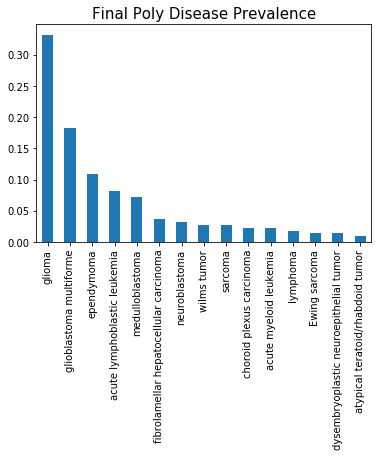

In [21]:
(poly_clinical_disease_common_sumbsampled_final.disease.value_counts()/poly_clinical_disease_common_sumbsampled_final.disease.value_counts().sum()).plot(kind='bar')
plt.title('Final Poly Disease Prevalence', fontsize=15)
plt.show()
plt.close()

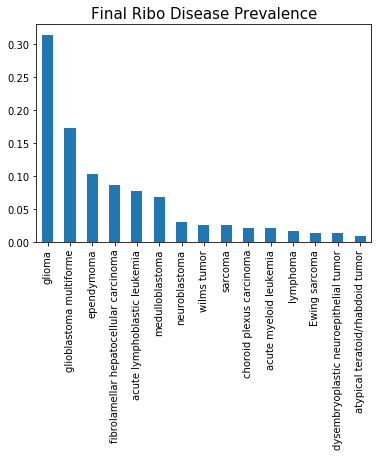

In [22]:
(ribo_clinical_disease_common.disease.value_counts()/ribo_clinical_disease_common.disease.value_counts().sum()).plot(kind='bar')
plt.title('Final Ribo Disease Prevalence', fontsize=15)
plt.show()
plt.close()